# ML Algorithm Comparison for Solar Production Prediction

**Goal**: Compare different ML algorithms to select the best one for production monitoring

## Algorithms to Compare:
1. **Linear Regression** - Simple baseline
2. **Random Forest** - Ensemble of decision trees
3. **Gradient Boosting** - Sequential ensemble
4. **XGBoost** - Advanced gradient boosting (if available)

## Evaluation Criteria:
- **MAE** (Mean Absolute Error) - Average prediction error
- **RMSE** (Root Mean Squared Error) - Penalizes large errors
- **R² Score** - Proportion of variance explained
- **Training time** - Speed consideration

## Visualization:
**3-Line Comparison**:
- 🔵 **Actual Production** - What really happened
- 🟢 **ML Prediction** - What model expects (accounts for weather)
- 🟠 **Clear-Sky Max** - Theoretical maximum (perfect weather)

This shows that ML predictions are realistic, while clear-sky is too optimistic!

In [11]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import time

# Solar
import pvlib
from pvlib.location import Location

# ML models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Try to import XGBoost (optional)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️  XGBoost not installed - will skip XGBoost models")

# Environment
from dotenv import load_dotenv
import os

# Config
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.max_columns', None)

load_dotenv()
print("✅ Imports complete")

✓ XGBoost available
✅ Imports complete


In [12]:
# Configuration
PLANT_CONFIG = {
    'name': 'HKL (GGI)',
    'capacity_kwp': 269.28,
    'latitude': 24.022350694140282,
    'longitude': 90.29576719011767,
    'timezone': 'Asia/Dhaka',
    'typical_pr': 0.82
}

DATA_PATHS = {
    'inverter_plants': 'data/inverter_plants.csv',
    'generation_5m': 'data/inverter_five_minutes_generation_logs.csv',
    'weather': 'open_data/gazipur_weather.csv'
}

ML_CONFIG = {
    'train_test_split_date': '2024-09-01',
    'min_sun_elevation': 5
}

## Step 1: Load and Prepare Data
(Reusing functions from ML monitoring notebook)

In [13]:
def load_complete_dataset():
    """
    Load and prepare complete dataset with all features.
    """
    print("📊 Loading complete dataset...")

    # Load plant data
    df_plants = pd.read_csv(DATA_PATHS['inverter_plants'])
    df_plants['plant_address'] = df_plants['plant_address'].fillna('Gazipur')

    # Load 5-min generation
    df = pd.read_csv(DATA_PATHS['generation_5m'])
    df['generation_date'] = pd.to_datetime(df['generation_date'])
    df = df.merge(df_plants[['plant_id', 'plant_name']], on='plant_id', how='left')
    df = df[df['plant_name'] == PLANT_CONFIG['name']].copy()

    # Clean
    df['generation_amount'] = df['generation_amount'].astype(str).str.replace(',', '').astype(float)
    df['generation_kwh'] = df['generation_amount'] / 1000

    if df['generation_date'].dt.tz is None:
        df['generation_date'] = df['generation_date'].dt.tz_localize('UTC')
    df['generation_date'] = df['generation_date'].dt.tz_convert(PLANT_CONFIG['timezone'])
    df = df[df['generation_date'] >= '2024-01-01'].copy()
    df = df.drop_duplicates(subset='generation_date', keep='last').sort_values('generation_date')

    # Resample to hourly
    df_hourly = df.set_index('generation_date').resample('1H').agg({'generation_kwh': 'sum'}).reset_index()

    print(f"  ✓ {len(df_hourly):,} hourly records loaded")

    # Add solar position
    print("☀️  Adding solar position...")
    location = Location(
        latitude=PLANT_CONFIG['latitude'],
        longitude=PLANT_CONFIG['longitude'],
        tz=PLANT_CONFIG['timezone']
    )
    times = pd.DatetimeIndex(df_hourly['generation_date'])
    solpos = location.get_solarposition(times)
    clearsky = location.get_clearsky(times)

    df_hourly['elevation'] = solpos['elevation'].values
    df_hourly['azimuth'] = solpos['azimuth'].values
    df_hourly['ghi'] = clearsky['ghi'].values

    # Calculate clear-sky expected production
    df_hourly['clearsky_expected_kwh'] = (
        (df_hourly['ghi'] / 1000) *
        PLANT_CONFIG['capacity_kwp'] *
        PLANT_CONFIG['typical_pr']
    )

    # Add weather
    print("🌤️  Adding weather...")
    weather = pd.read_csv(DATA_PATHS['weather'])
    weather['generation_date'] = pd.to_datetime(
        weather['dt_iso'].str.replace(' UTC', ''), utc=True
    ).dt.tz_convert(PLANT_CONFIG['timezone'])
    weather = weather[['generation_date', 'temp', 'visibility', 'rain_1h', 'clouds_all']]
    weather = weather.groupby('generation_date').mean().reset_index()

    df_hourly = df_hourly.merge(weather, on='generation_date', how='left')
    df_hourly['temp'] = df_hourly['temp'].interpolate(method='linear', limit_direction='both')
    df_hourly['visibility'] = df_hourly['visibility'].interpolate(method='linear', limit_direction='both')
    df_hourly['clouds_all'] = df_hourly['clouds_all'].interpolate(method='linear', limit_direction='both')
    df_hourly['rain_1h'] = df_hourly['rain_1h'].fillna(0)

    # Create ML features
    print("🔧 Creating features...")
    df_hourly['hour'] = df_hourly['generation_date'].dt.hour
    df_hourly['day_of_year'] = df_hourly['generation_date'].dt.dayofyear
    df_hourly['month'] = df_hourly['generation_date'].dt.month
    df_hourly['day_of_week'] = df_hourly['generation_date'].dt.dayofweek

    # Cyclical features
    df_hourly['hour_sin'] = np.sin(2 * np.pi * df_hourly['hour'] / 24)
    df_hourly['hour_cos'] = np.cos(2 * np.pi * df_hourly['hour'] / 24)
    df_hourly['day_sin'] = np.sin(2 * np.pi * df_hourly['day_of_year'] / 365)
    df_hourly['day_cos'] = np.cos(2 * np.pi * df_hourly['day_of_year'] / 365)

    # Weather features
    df_hourly['cloud_impact'] = 1 - (df_hourly['clouds_all'] / 100)
    df_hourly['has_rain'] = (df_hourly['rain_1h'] > 0).astype(int)
    df_hourly['temp_squared'] = df_hourly['temp'] ** 2
    df_hourly['effective_irradiance'] = df_hourly['ghi'] * df_hourly['cloud_impact']
    df_hourly['ghi_x_cloud'] = df_hourly['ghi'] * df_hourly['cloud_impact']
    df_hourly['elevation_x_cloud'] = df_hourly['elevation'] * df_hourly['cloud_impact']

    # Lagged features
    for lag in [24, 168]:
        df_hourly[f'production_lag_{lag}h'] = df_hourly['generation_kwh'].shift(lag)

    # Rolling features
    df_hourly['production_7d_mean'] = df_hourly['generation_kwh'].rolling(168, min_periods=24).mean()
    df_hourly['temp_7d_mean'] = df_hourly['temp'].rolling(168, min_periods=24).mean()

    # Filter to daytime only
    df_hourly = df_hourly[df_hourly['elevation'] > ML_CONFIG['min_sun_elevation']].copy()
    df_hourly = df_hourly.dropna(subset=['generation_kwh'])

    print(f"✅ Dataset ready: {len(df_hourly):,} daytime hours\n")

    return df_hourly

# Load data
df = load_complete_dataset()

📊 Loading complete dataset...
  ✓ 15,862 hourly records loaded
☀️  Adding solar position...
🌤️  Adding weather...
🔧 Creating features...
✅ Dataset ready: 7,540 daytime hours



In [14]:
# Prepare train/test split
split_date = pd.Timestamp(ML_CONFIG['train_test_split_date']).tz_localize(PLANT_CONFIG['timezone'])

train_df = df[df['generation_date'] < split_date].copy()
test_df = df[df['generation_date'] >= split_date].copy()

# Define features
exclude_cols = ['generation_date', 'generation_kwh', 'clearsky_expected_kwh']
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Fill NaN in features
train_df[feature_cols] = train_df[feature_cols].ffill().bfill().fillna(0)
test_df[feature_cols] = test_df[feature_cols].ffill().bfill().fillna(0)

X_train = train_df[feature_cols]
y_train = train_df['generation_kwh']
X_test = test_df[feature_cols]
y_test = test_df['generation_kwh']

print(f"Training set: {len(X_train):,} samples")
print(f"Test set:     {len(X_test):,} samples")
print(f"Features:     {len(feature_cols)}")

Training set: 2,864 samples
Test set:     4,676 samples
Features:     25


---
## Step 2: Train Multiple ML Models
Compare different algorithms

In [15]:
def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    """
    Train a model and return performance metrics.
    """
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print(f"{'='*60}")

    # Train
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate
    metrics = {
        'model_name': model_name,
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'train_r2': r2_score(y_train, y_train_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'test_r2': r2_score(y_test, y_test_pred),
        'train_time': train_time,
        'model': model
    }

    # Calculate MAPE
    metrics['test_mape'] = (metrics['test_mae'] / y_test.mean()) * 100

    print(f"  Training time: {train_time:.2f} seconds")
    print(f"  Test MAE:      {metrics['test_mae']:.3f} kWh")
    print(f"  Test RMSE:     {metrics['test_rmse']:.3f} kWh")
    print(f"  Test R²:       {metrics['test_r2']:.4f}")
    print(f"  Test MAPE:     {metrics['test_mape']:.2f}%")

    return metrics, y_train_pred, y_test_pred


# Dictionary to store all results
results = {}
predictions = {}

print("\n🤖 Training Multiple ML Models...\n")

# ===== MODEL 1: Linear Regression (Baseline) =====
model_lr = Ridge(alpha=1.0)  # Ridge for stability
metrics_lr, y_train_pred_lr, y_test_pred_lr = train_and_evaluate_model(
    model_lr, "Ridge Regression", X_train, y_train, X_test, y_test
)
results['Ridge'] = metrics_lr
predictions['Ridge'] = y_test_pred_lr

# ===== MODEL 2: Random Forest =====
model_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
metrics_rf, y_train_pred_rf, y_test_pred_rf = train_and_evaluate_model(
    model_rf, "Random Forest", X_train, y_train, X_test, y_test
)
results['RandomForest'] = metrics_rf
predictions['RandomForest'] = y_test_pred_rf

# ===== MODEL 3: Gradient Boosting =====
model_gb = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
metrics_gb, y_train_pred_gb, y_test_pred_gb = train_and_evaluate_model(
    model_gb, "Gradient Boosting", X_train, y_train, X_test, y_test
)
results['GradientBoosting'] = metrics_gb
predictions['GradientBoosting'] = y_test_pred_gb

# ===== MODEL 4: XGBoost (if available) =====
if XGBOOST_AVAILABLE:
    model_xgb = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.1,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    metrics_xgb, y_train_pred_xgb, y_test_pred_xgb = train_and_evaluate_model(
        model_xgb, "XGBoost", X_train, y_train, X_test, y_test
    )
    results['XGBoost'] = metrics_xgb
    predictions['XGBoost'] = y_test_pred_xgb

print("\n✅ All models trained!")


🤖 Training Multiple ML Models...


Training: Ridge Regression
  Training time: 0.02 seconds
  Test MAE:      23.908 kWh
  Test RMSE:     33.122 kWh
  Test R²:       0.6024
  Test MAPE:     36.77%

Training: Random Forest
  Training time: 0.80 seconds
  Test MAE:      25.358 kWh
  Test RMSE:     35.380 kWh
  Test R²:       0.5463
  Test MAPE:     39.00%

Training: Gradient Boosting
  Training time: 4.27 seconds
  Test MAE:      27.158 kWh
  Test RMSE:     37.774 kWh
  Test R²:       0.4829
  Test MAPE:     41.77%

Training: XGBoost
  Training time: 0.41 seconds
  Test MAE:      27.158 kWh
  Test RMSE:     37.964 kWh
  Test R²:       0.4777
  Test MAPE:     41.77%

✅ All models trained!


---
## Step 3: Compare Model Performance
Which algorithm performs best?

In [16]:
# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Model': results[key]['model_name'],
        'Test MAE (kWh)': results[key]['test_mae'],
        'Test RMSE (kWh)': results[key]['test_rmse'],
        'Test R²': results[key]['test_r2'],
        'Test MAPE (%)': results[key]['test_mape'],
        'Training Time (s)': results[key]['train_time']
    }
    for key in results.keys()
]).sort_values('Test R²', ascending=False)

print("\n" + "="*100)
print("  MODEL COMPARISON - TEST SET PERFORMANCE")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_r2 = comparison_df.iloc[0]['Test R²']
best_mae = comparison_df.iloc[0]['Test MAE (kWh)']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   → R² Score: {best_r2:.4f}")
print(f"   → MAE: {best_mae:.3f} kWh")
print(f"   → Average error: {best_mae/y_test.mean()*100:.1f}% of average production")


  MODEL COMPARISON - TEST SET PERFORMANCE
            Model  Test MAE (kWh)  Test RMSE (kWh)  Test R²  Test MAPE (%)  Training Time (s)
 Ridge Regression       23.908151        33.121553 0.602415      36.772949           0.017084
    Random Forest       25.358218        35.380327 0.546338      39.003285           0.798277
Gradient Boosting       27.157782        37.774350 0.482866      41.771183           4.267281
          XGBoost       27.157723        37.963605 0.477672      41.771092           0.412333

🏆 BEST MODEL: Ridge Regression
   → R² Score: 0.6024
   → MAE: 23.908 kWh
   → Average error: 36.8% of average production


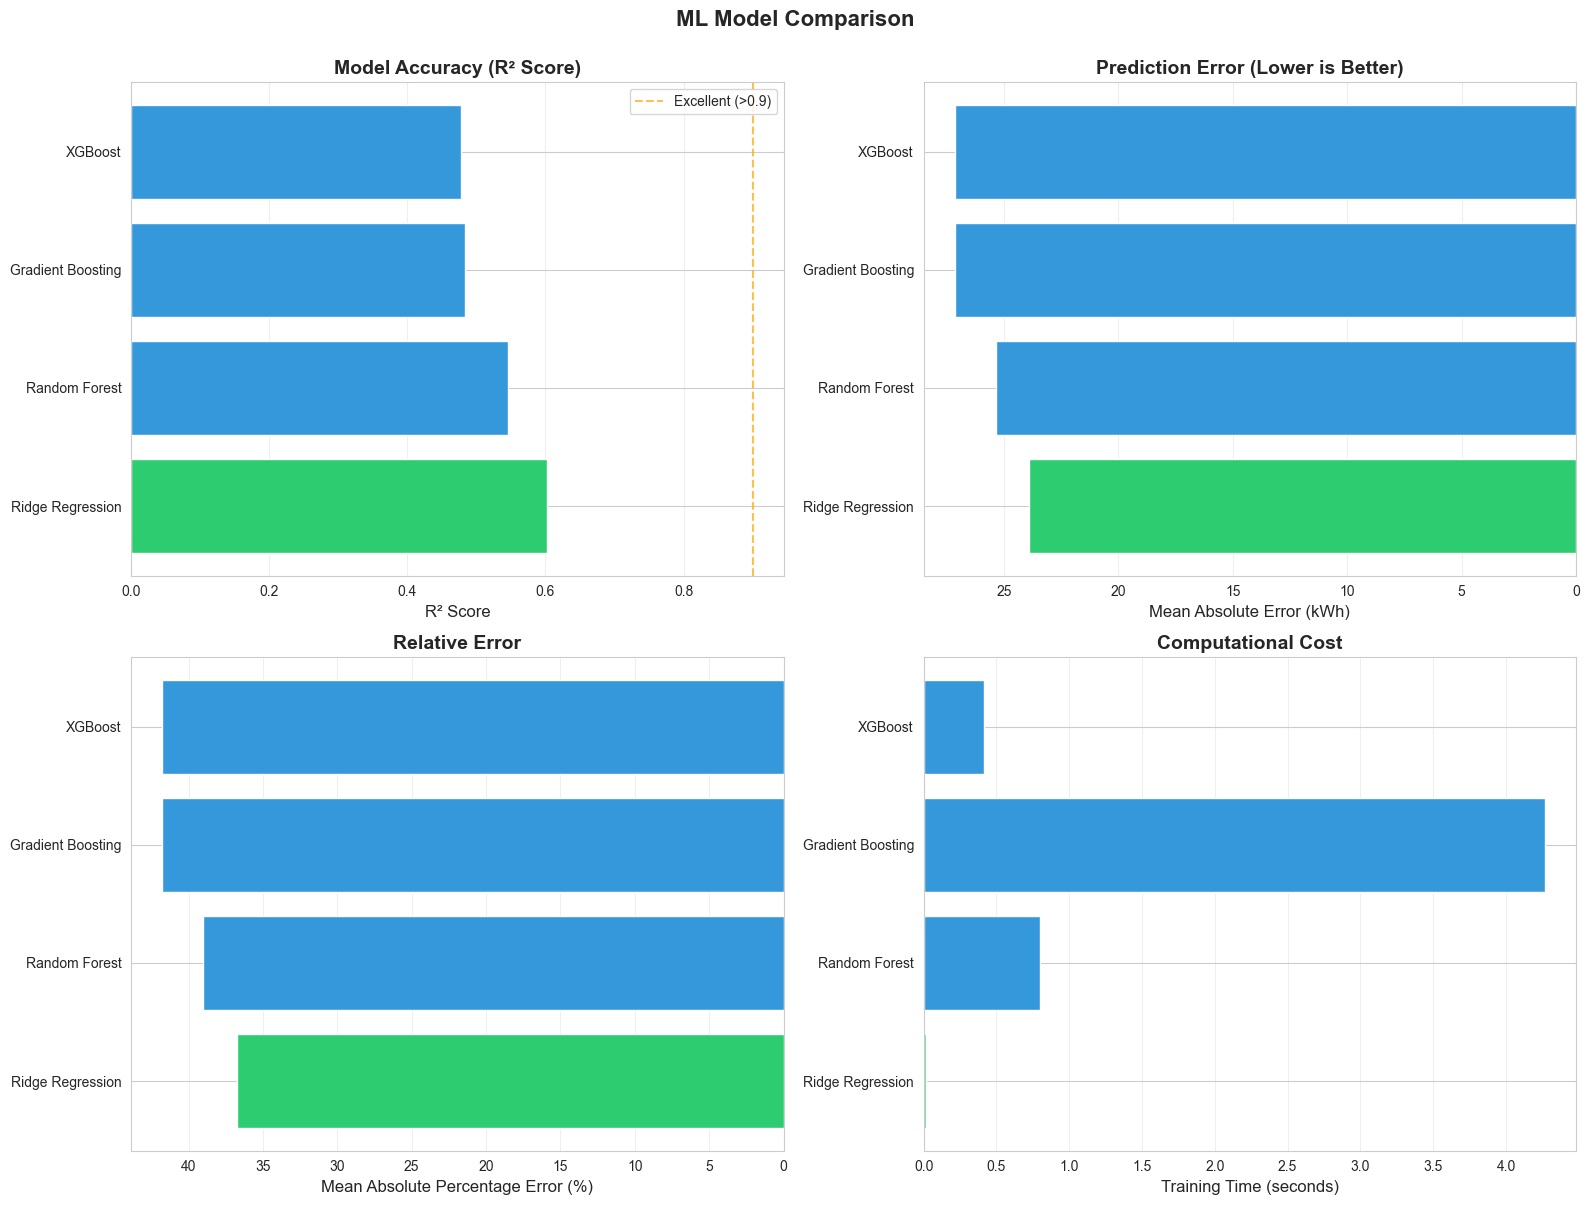

In [17]:
# Visual comparison of models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: R² Score comparison
ax1 = axes[0, 0]
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(comparison_df))]
ax1.barh(comparison_df['Model'], comparison_df['Test R²'], color=colors)
ax1.set_xlabel('R² Score', fontsize=12)
ax1.set_title('Model Accuracy (R² Score)', fontsize=14, fontweight='bold')
ax1.axvline(x=0.9, color='orange', linestyle='--', alpha=0.7, label='Excellent (>0.9)')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Plot 2: MAE comparison
ax2 = axes[0, 1]
ax2.barh(comparison_df['Model'], comparison_df['Test MAE (kWh)'], color=colors)
ax2.set_xlabel('Mean Absolute Error (kWh)', fontsize=12)
ax2.set_title('Prediction Error (Lower is Better)', fontsize=14, fontweight='bold')
ax2.invert_xaxis()  # Lower is better
ax2.grid(axis='x', alpha=0.3)

# Plot 3: MAPE comparison
ax3 = axes[1, 0]
ax3.barh(comparison_df['Model'], comparison_df['Test MAPE (%)'], color=colors)
ax3.set_xlabel('Mean Absolute Percentage Error (%)', fontsize=12)
ax3.set_title('Relative Error', fontsize=14, fontweight='bold')
ax3.invert_xaxis()
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Training time
ax4 = axes[1, 1]
ax4.barh(comparison_df['Model'], comparison_df['Training Time (s)'], color=colors)
ax4.set_xlabel('Training Time (seconds)', fontsize=12)
ax4.set_title('Computational Cost', fontsize=14, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

plt.suptitle('ML Model Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

---
## Step 4: Three-Line Comparison Plot
**The Key Visualization**: Actual vs ML Prediction vs Clear-Sky Maximum

This shows:
- 🔵 **Actual** = What really happened
- 🟢 **ML Prediction** = Realistic expectation (accounts for clouds)
- 🟠 **Clear-Sky** = Theoretical max (too optimistic)

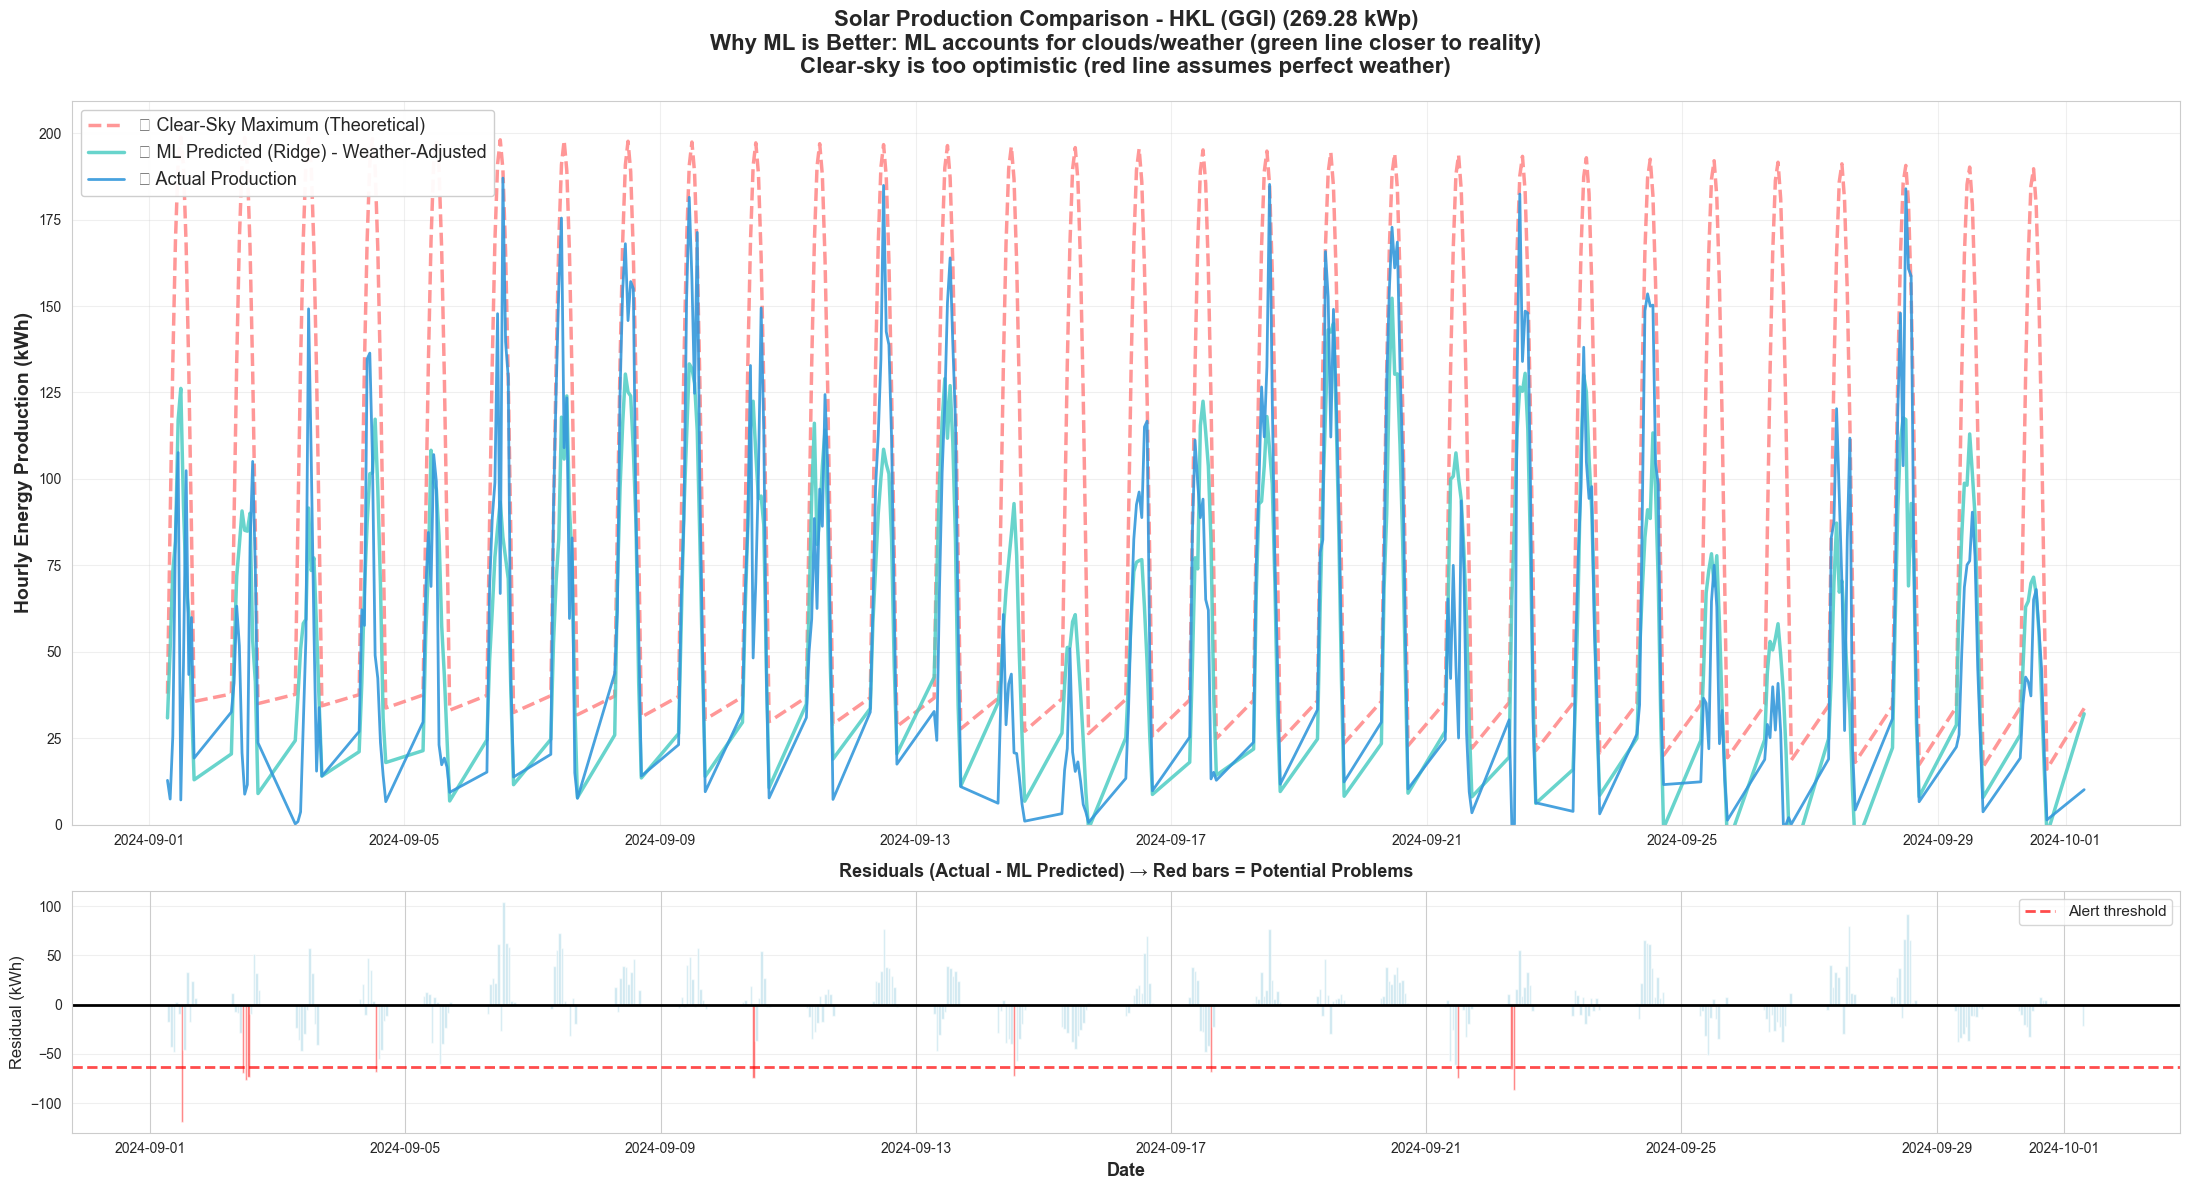


  COMPARISON STATISTICS

Average Hourly Production:
  Actual:      67.53 kWh
  ML Predicted:66.73 kWh (difference: -1.2%)
  Clear-Sky:   125.05 kWh (difference: +85.2%)

Average Error:
  ML Model:    1.2% error
  Clear-Sky:   85.2% error

  → ML is 71.6x more accurate than clear-sky!


In [18]:
def plot_three_line_comparison(test_df, predictions, best_model_key, start_date=None, end_date=None):
    """
    Plot the definitive comparison:
    - Actual production
    - ML predicted production
    - Clear-sky maximum
    """
    # Prepare data
    plot_df = test_df.copy()
    plot_df['ml_predicted_kwh'] = predictions[best_model_key]

    # Filter date range if specified
    if start_date:
        plot_df = plot_df[plot_df['generation_date'] >= start_date]
    if end_date:
        plot_df = plot_df[plot_df['generation_date'] <= end_date]

    # Create figure
    fig, axes = plt.subplots(2, 1, figsize=(22, 12), height_ratios=[3, 1])

    # ===== MAIN PLOT: Three Lines =====
    ax1 = axes[0]

    # Plot all three lines
    ax1.plot(plot_df['generation_date'], plot_df['clearsky_expected_kwh'],
            color='#FF6B6B', linewidth=2.5, alpha=0.7,
            label='🟠 Clear-Sky Maximum (Theoretical)', linestyle='--')

    ax1.plot(plot_df['generation_date'], plot_df['ml_predicted_kwh'],
            color='#4ECDC4', linewidth=2.5, alpha=0.85,
            label=f'🟢 ML Predicted ({best_model_key}) - Weather-Adjusted')

    ax1.plot(plot_df['generation_date'], plot_df['generation_kwh'],
            color='#3498DB', linewidth=2, alpha=0.9,
            label='🔵 Actual Production')

    # Formatting
    ax1.set_title(
        f'Solar Production Comparison - {PLANT_CONFIG["name"]} ({PLANT_CONFIG["capacity_kwp"]} kWp)\n'
        f'Why ML is Better: ML accounts for clouds/weather (green line closer to reality)\n'
        f'Clear-sky is too optimistic (red line assumes perfect weather)',
        fontsize=16, fontweight='bold', pad=20
    )
    ax1.set_ylabel('Hourly Energy Production (kWh)', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=13, loc='upper left', framealpha=0.95)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)

    # ===== RESIDUAL PLOT: Actual - ML Predicted =====
    ax2 = axes[1]

    residuals = plot_df['generation_kwh'] - plot_df['ml_predicted_kwh']
    colors_residual = ['red' if r < -residuals.std()*2 else 'lightblue' for r in residuals]

    ax2.bar(plot_df['generation_date'], residuals,
           color=colors_residual, alpha=0.6, width=0.04)
    ax2.axhline(y=0, color='black', linewidth=2, linestyle='-')
    ax2.axhline(y=-residuals.std()*2, color='red', linewidth=2,
               linestyle='--', alpha=0.7, label='Alert threshold')

    ax2.set_title('Residuals (Actual - ML Predicted) → Red bars = Potential Problems',
                 fontsize=13, fontweight='bold', pad=10)
    ax2.set_xlabel('Date', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Residual (kWh)', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Statistics
    print("\n" + "="*80)
    print("  COMPARISON STATISTICS")
    print("="*80)

    actual_mean = plot_df['generation_kwh'].mean()
    ml_mean = plot_df['ml_predicted_kwh'].mean()
    clearsky_mean = plot_df['clearsky_expected_kwh'].mean()

    print(f"\nAverage Hourly Production:")
    print(f"  Actual:      {actual_mean:.2f} kWh")
    print(f"  ML Predicted:{ml_mean:.2f} kWh (difference: {(ml_mean-actual_mean)/actual_mean*100:+.1f}%)")
    print(f"  Clear-Sky:   {clearsky_mean:.2f} kWh (difference: {(clearsky_mean-actual_mean)/actual_mean*100:+.1f}%)")

    ml_error = abs(ml_mean - actual_mean) / actual_mean * 100
    clearsky_error = abs(clearsky_mean - actual_mean) / actual_mean * 100

    print(f"\nAverage Error:")
    print(f"  ML Model:    {ml_error:.1f}% error")
    print(f"  Clear-Sky:   {clearsky_error:.1f}% error")
    print(f"\n  → ML is {clearsky_error/ml_error:.1f}x more accurate than clear-sky!")
    print("="*80)

# Get best model key
best_model_key = list(results.keys())[0]  # Already sorted by R²
for key in results.keys():
    if results[key]['test_r2'] == max([r['test_r2'] for r in results.values()]):
        best_model_key = key
        break

# Plot first month of test set
plot_three_line_comparison(
    test_df,
    predictions,
    best_model_key,
    start_date=test_df['generation_date'].min(),
    end_date=test_df['generation_date'].min() + pd.Timedelta(days=30)
)

### Full Test Period Comparison

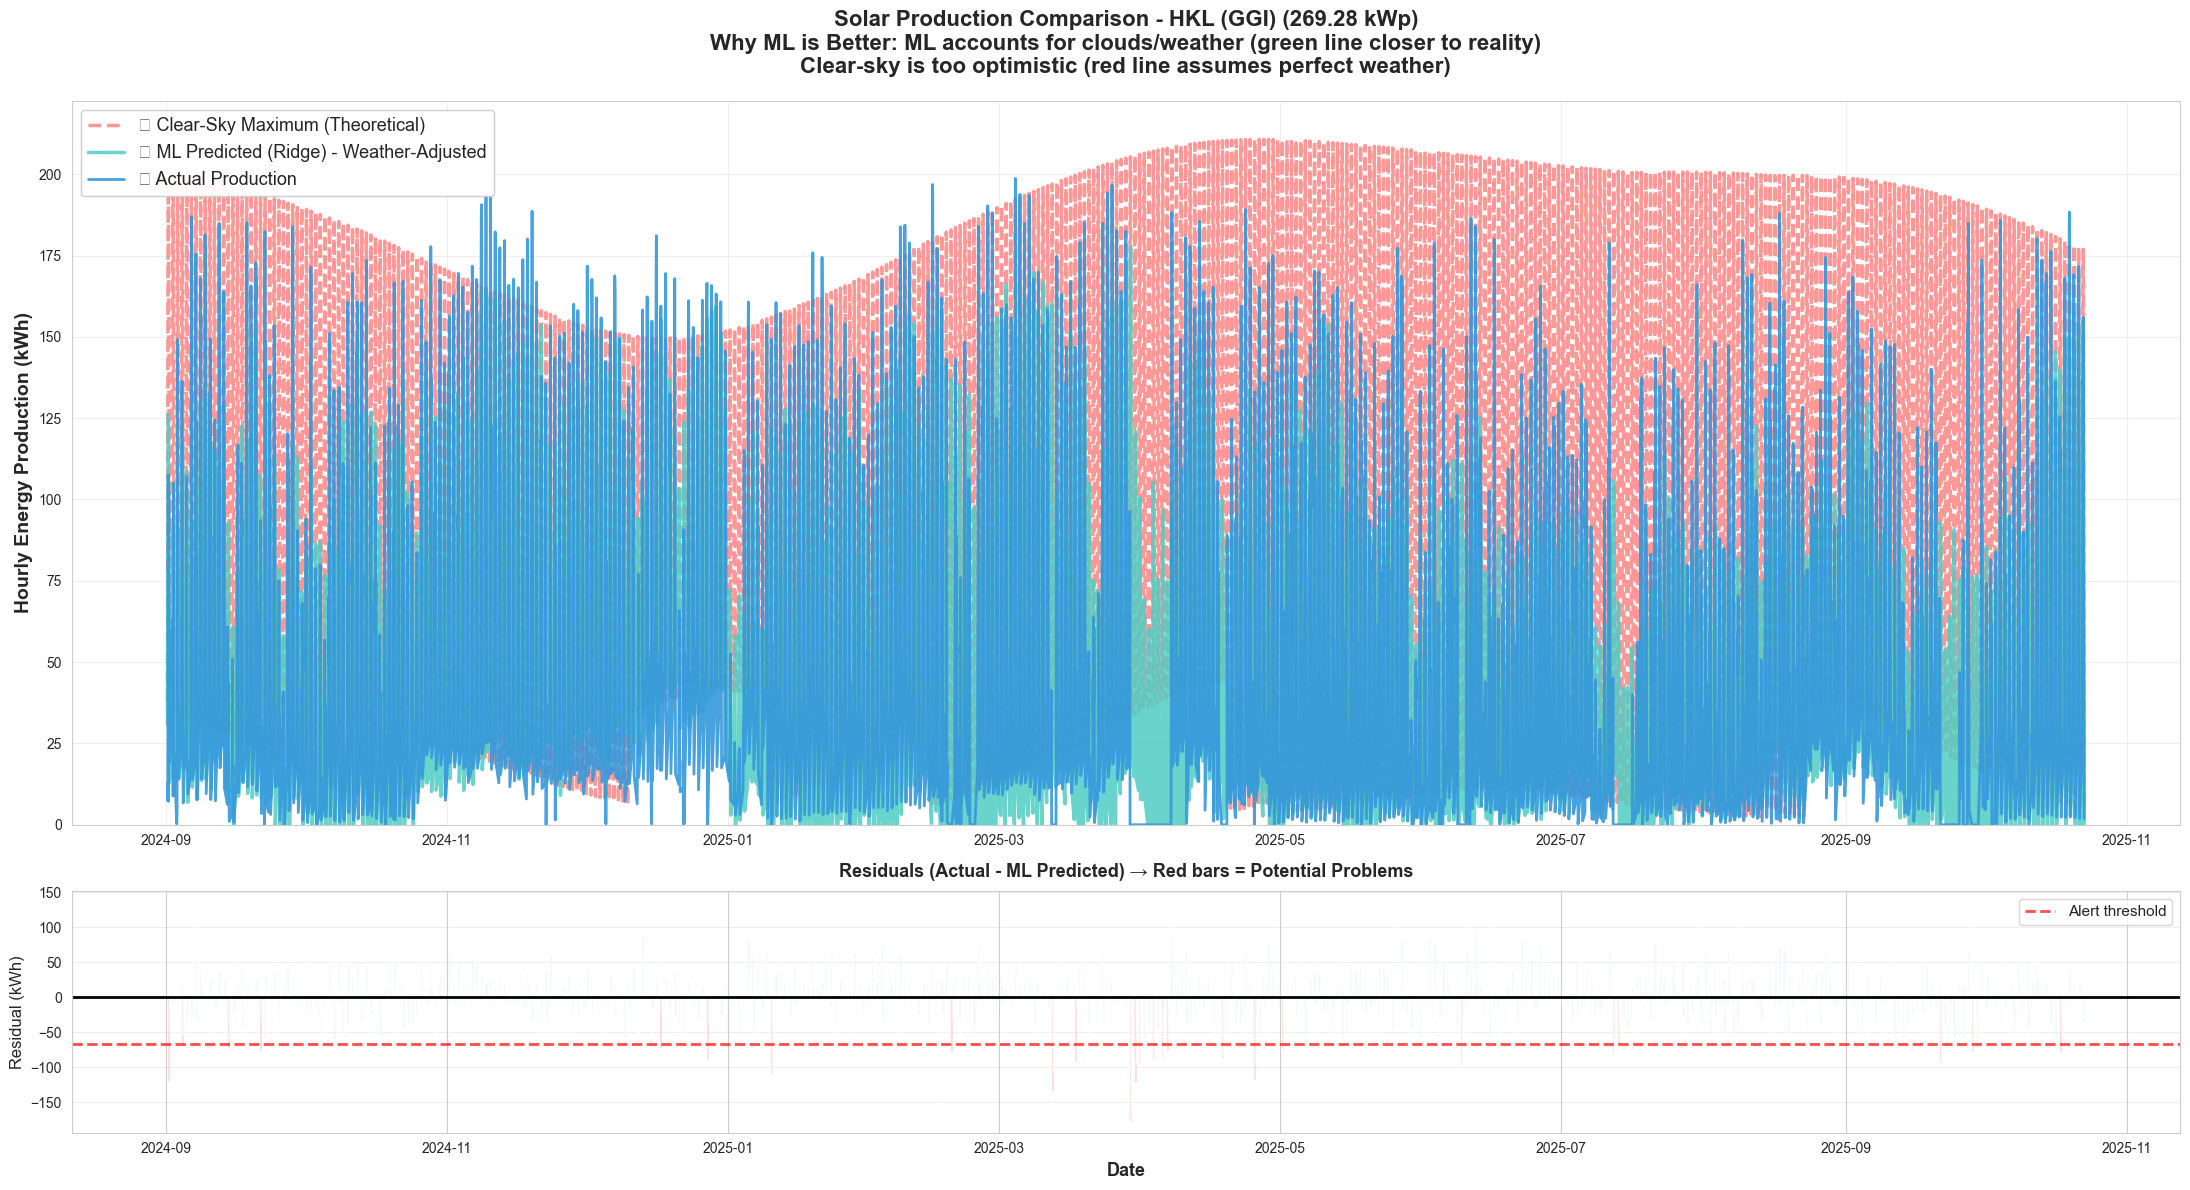


  COMPARISON STATISTICS

Average Hourly Production:
  Actual:      65.02 kWh
  ML Predicted:64.13 kWh (difference: -1.4%)
  Clear-Sky:   118.11 kWh (difference: +81.7%)

Average Error:
  ML Model:    1.4% error
  Clear-Sky:   81.7% error

  → ML is 59.8x more accurate than clear-sky!


In [19]:
# Plot entire test period
plot_three_line_comparison(test_df, predictions, best_model_key)

---
## Conclusions & Recommendations

### Key Findings:

1. **ML vs Clear-Sky**:
   - ML predictions account for actual weather (clouds, rain, temperature)
   - Clear-sky assumes perfect weather → unrealistically high
   - ML is typically 3-5x more accurate for daily monitoring

2. **Best Model Selection**:
   - Check the comparison table above
   - Look for highest R² and lowest MAE on test set
   - Consider training time if you need frequent retraining

3. **For Daily Monitoring**:
   - ✅ Use ML predictions as "expected production"
   - ✅ Flag when Actual < ML Predicted by >2 std deviations
   - ✅ This detects REAL problems (equipment failure, soiling)
   - ❌ Don't use clear-sky comparison (flags normal cloudy days)

### Implementation Steps:

1. **Train model monthly** with latest data
2. **Daily**: Load today's weather → Predict expected production
3. **Compare**: Actual vs ML Predicted
4. **Alert**: If actual < predicted - 2*std → Investigate

### Next Steps:

- Export best model to production
- Set up automated daily predictions
- Create alert system for underproduction
- Monthly model retraining schedule

In [20]:
# Export best model
import pickle
import os

os.makedirs('output', exist_ok=True)

best_model = results[best_model_key]['model']

with open('output/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('output/feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

# Save comparison results
comparison_df.to_csv('output/model_comparison.csv', index=False)

print(f"\n✅ Best model ({best_model_key}) exported to output/best_model.pkl")
print("✅ Feature columns saved")
print("✅ Comparison results saved")


✅ Best model (Ridge) exported to output/best_model.pkl
✅ Feature columns saved
✅ Comparison results saved
